This notebook has a neural network learn a harmonic function.

### Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dataclasses
import sys

import math
import matplotlib.pyplot as plt
import mlflow
import optax

import tensorflow as tf
import tensorflow.keras as keras

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [3]:
sys.path.append("..")

import src.models.mlp as mlp
import src.utils as utils
from src.experiments.harmonics.run_experiment import ExperimentConfig
from src.experiments.harmonics.harmonic_function import HarmonicFunction

### Experiment set up

ExperimentConfig(input_dim=2, freq_limit=4, num_components=8, layer_widths=(96, 192, 1), n_test=10000, ds_test_seed=-2, train_sizes=(1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144), trials_per_size=5, early_stopping=True, early_stopping_patience=32, early_stopping_monitor='val_loss', learning_rate=0.0003, max_epochs=9001, batch_size=256, l2_reg=0)


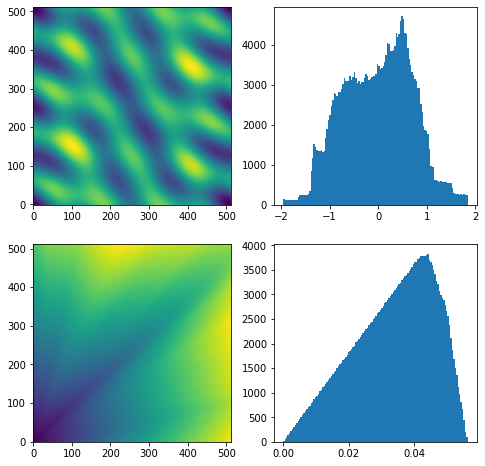

In [28]:
#%debug
cfg = ExperimentConfig(
    freq_limit=4,
    learning_rate=3e-4,
    layer_widths=(96, 192, 1),
    batch_size=256,
    early_stopping_monitor="val_loss",
)
print(cfg)

hf = HarmonicFunction(
    input_dim=cfg.input_dim,
    freq_limit=cfg.freq_limit,
    num_components=cfg.num_components,
    seed=-1,
)

tf.random.set_seed(12)
student = keras.Sequential(
    [keras.Input(shape=(cfg.input_dim,))]
    + [keras.layers.Dense(w, activation="relu") for w in cfg.layer_widths[:-1]]
    + [keras.layers.Dense(cfg.layer_widths[-1])]
)

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
img = utils.to_2d_image(hf._predict, side_samples=512).numpy()
plt.imshow(img, origin="lower")
plt.subplot(2, 2, 2)
plt.hist(img.flatten(), bins=128);

plt.subplot(2, 2, 3)
img = utils.to_2d_image(lambda xs: student.predict(tf.convert_to_tensor(xs.reshape(-1, 2))).reshape(512, 512), side_samples=512)
plt.imshow(img, origin="lower");
plt.subplot(2, 2, 4)
plt.hist(img.flatten(), bins=128);

In [44]:
student.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 96)                288       
                                                                 
 dense_16 (Dense)            (None, 192)               18624     
                                                                 
 dense_17 (Dense)            (None, 1)                 193       
                                                                 
Total params: 19,105
Trainable params: 19,105
Non-trainable params: 0
_________________________________________________________________


In [29]:
student.predict([[0.5, 0.5]])

array([[0.02356851]], dtype=float32)

### Training

In [30]:
ds_test = hf.get_iid_dataset(
    n_samples=cfg.n_test,
    seed=-2,
    batch_size=cfg.batch_size,
)
ds_test["xs"].shape, ds_test["ys"].shape

ds_train = hf.get_iid_dataset(
    n_samples=50000,
    batch_size=cfg.batch_size,
    seed=43,
)
ds_train["xs"].shape, ds_train["ys"].shape

(TensorShape([50000, 2]), TensorShape([50000]))

In [31]:
student.compile(
    optimizer=keras.optimizers.Adam(learning_rate=cfg.learning_rate),
    loss=keras.losses.MeanSquaredError(),
)

hist = student.fit(
    x=ds_train["xs"],
    y=ds_train["ys"],
    validation_data=(ds_test["xs"], ds_test["ys"]),
    batch_size=cfg.batch_size,
    shuffle=True,
    epochs=cfg.max_epochs,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor=cfg.early_stopping_monitor,
            patience=cfg.early_stopping_patience,
            mode="min",
        )
    ]
    if cfg.early_stopping
    else [],
    verbose=True,
)

Epoch 1/9001
196/196 [==============================] - 1s 2ms/step - loss: 0.4885 - val_loss: 0.4875
Epoch 2/9001
196/196 [==============================] - 0s 2ms/step - loss: 0.4775 - val_loss: 0.4770
Epoch 3/9001
196/196 [==============================] - 0s 2ms/step - loss: 0.4695 - val_loss: 0.4707
Epoch 4/9001
196/196 [==============================] - 0s 2ms/step - loss: 0.4636 - val_loss: 0.4649
Epoch 5/9001
196/196 [==============================] - 0s 2ms/step - loss: 0.4562 - val_loss: 0.4585
Epoch 6/9001
196/196 [==============================] - 0s 2ms/step - loss: 0.4472 - val_loss: 0.4475
Epoch 7/9001
196/196 [==============================] - 0s 2ms/step - loss: 0.4371 - val_loss: 0.4380
Epoch 8/9001
196/196 [==============================] - 0s 2ms/step - loss: 0.4261 - val_loss: 0.4269
Epoch 9/9001
196/196 [==============================] - 0s 2ms/step - loss: 0.4166 - val_loss: 0.4184
Epoch 10/9001
196/196 [==============================] - 0s 2ms/step - loss: 0.407

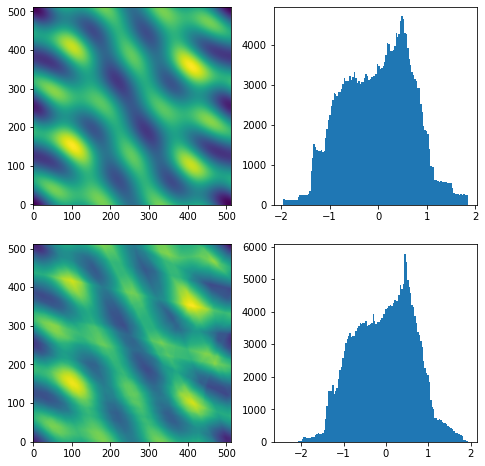

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
img = utils.to_2d_image(hf._predict, side_samples=512).numpy()
plt.imshow(img, origin="lower")
plt.subplot(2, 2, 2)
plt.hist(img.flatten(), bins=128);

plt.subplot(2, 2, 3)
img = utils.to_2d_image(lambda xs: student.predict(tf.convert_to_tensor(xs.reshape(-1, 2))).reshape(512, 512), side_samples=512)
plt.imshow(img, origin="lower");
plt.subplot(2, 2, 4)
plt.hist(img.flatten(), bins=128);

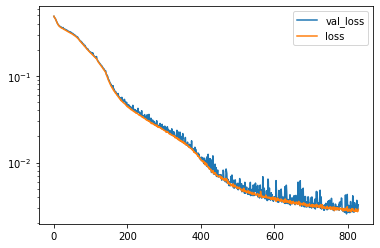

In [43]:
plt.plot(hist.history['val_loss'], label='val_loss')
plt.plot(hist.history['loss'], label='loss')
plt.legend();
plt.yscale('log')